<a href="https://colab.research.google.com/github/RomaricKanyamibwa/Normalisation-de-concepts-medicaux/blob/master/CNN_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import logging


Using TensorFlow backend.


In [0]:
!pip3 install --upgrade gensim

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
from gensim.models import Word2Vec
import gensim
import pandas as pd
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np

In [7]:
!mkdir drive
!google-drive-ocamlfuse drive
!ls drive/Word2VecModels/
!ls -l drive/Coolab/

mkdir: cannot create directory ‘drive’: File exists
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
model_2_LivingBeingsTrainingSet.bin
modelLivingBeingsTrainingSet.bin
modelPourRomaricLivingBeingsTrainingSet.bin
total 933477
-rw-r--r-- 1 root root     62531 Feb  4 15:24 CNN_projet.ipynb
-rw-r--r-- 1 root root  20688992 Dec 13 20:53 Disorders
-rw-r--r-- 1 root root  62187545 Nov 25 22:57 Disorders.csv
-rw-r--r-- 1 root root   3117869 Dec 15 14:13 DisordersNoCodes
-rw-r--r-- 1 root root  57394928 Dec 15 14:13 DisordersNoCodes.trainables.syn1neg.npy
-rw-r--r-- 1 root root  57394928 Dec 15 14:13 DisordersNoCodes.wv.vectors.npy
-rw-r--r-- 1 root root 377493728 Dec 13 20:53 Disorders.trainables.syn1neg.npy
-rw-r--r-- 1 root root 377493728 Dec 13 20:53 Disorders.wv.vectors.npy
-rw-r--r-- 1 root root      8864 Dec  8 20:50 loadmodel.ipynb
drwxr-xr-x 2 root root      4096 Dec  8 17:30 sg-s0200-w08-m004-ns05-s0.001-a0.025-i05
-rw-r--r-- 1 root r

In [8]:
google_drive="drive/Coolab/"
df_disorders=pd.read_csv("drive/Coolab/Disorders.csv",names=["Code","Disorder","GenDisorder"],sep="\t") 
num_rows=df_disorders.shape[0]

#step 2:Clean data
count_empty=df_disorders.isnull().sum()
count_non_empty=count_empty[count_empty==0]
print(count_non_empty)
#remove empty rows
df_disorders=df_disorders[count_non_empty.keys()]

Code           0
Disorder       0
GenDisorder    0
dtype: int64


In [72]:
GCodes=df_disorders['Code']#Y vector (outputs)
GDisorders=df_disorders['Disorder']#X vector(test)
GenDisorders=df_disorders['GenDisorder']#X vector (train)
print(len(GDisorders))
print(len(GCodes))

623509
623509


In [73]:
Gsample_size=25000#global sample size
sample_size=19000#train size
#train
GDisorders=GDisorders.sample(Gsample_size,random_state=10)
GCodes=GCodes[GDisorders.index]
len(GCodes)

25000

In [74]:
Disorders=GDisorders.sample(sample_size,random_state=10)
Codes=GCodes[Disorders.index]
len(Codes)

19000

In [75]:
#test set
#tsample_size=4000
#testDisorders=df_disorders['Disorder']
testDisorders=GDisorders.drop(Disorders.index)
#testDisorders=testDisorders.sample(tsample_size,random_state=10)
#testCodes=df_disorders['Code']
testCodes=GCodes[testDisorders.index]
len(testCodes)

6000

In [0]:
def removed_elements_generator(input_list):
    """This function creates an id generator of the empty tokenized elements"""
    
    logging.info("reading file {0}...this may take a while".format(input_list))
    
    for i, line in enumerate (input_list): 
        if (i%10000==0):
            logging.info ("read {0} reviews".format (i))
        # do some pre-processing and return a list of words for each review text
        line_process=remove_stopwords(line)
        line_process=gensim.utils.simple_preprocess(line_process,min_len=3,max_len=30)
        if not line_process:
          print(line_process,"before preprocess-",i,":",line)
          RemovedElements.append(i)
          #line_process=line.split()
          yield i

def input_tokenize(input_list,RemovedElements):
    """This creates a generator of the tokenized elements """
    
    logging.info("reading file {0}...this may take a while".format(input_list))
    
    for i, line in enumerate (input_list): 
        if (i%10000==0):
            logging.info ("read {0} reviews".format (i))
        # do some pre-processing and return a list of words for each review text
        line_process=remove_stopwords(line)
        line_process=gensim.utils.simple_preprocess(line_process,min_len=3,max_len=30)
        if not line_process:
          print(line_process,"before preprocess-",i,":",line)
          RemovedElements.append(i)
          #line_process=line.split()
        else:    
          yield line_process

In [0]:
model_dir=google_drive+"DisordersNoCodes"
model_w2vec=Word2Vec.load(model_dir)


In [0]:
def getsentence_matrix(sentence,gensim_model,nrows=30):
  #print("sent:",sentence)
  sentence_matrix=[gensim_model.wv.get_vector(token) for token in sentence]
 
  sentence_matrix=np.matrix(sentence_matrix)
#  print("Before padding:")
#  pprint(sentence_matrix.T[:2,:])
  #print("size before padding:",nrows-sentence_matrix.shape[0])
  if(nrows-sentence_matrix.shape[0]<0 or sentence_matrix.shape[1]<=0):
    print("Sentence:",sentence)
    print("MatrixShape:",sentence_matrix.shape)
    print(sentence_matrix)
  sentence_matrix=np.lib.pad(sentence_matrix,((0,max(0,nrows-sentence_matrix.shape[0])),(0,0)), 'constant', constant_values=(0))
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
#  print("After padding:")
#  pprint(sentence_matrix.T[:2,:])
  #print("shape=",sentence_matrix.shape)
  return sentence_matrix#.T

In [0]:
def get_termes_matrices(Corpus,model):
  
#  pprint(Corpus)
  matrix_list=[]
  IndexOfEmptyElem=[]
  nrows=30
  empty=True
  for i,sentence in enumerate(Corpus):
    if not(not sentence):
      if empty==True:
        matrix_list=np.array([getsentence_matrix(sentence,model,nrows=30)])
        empty=False
        #print(matrix_list[0].shape)
      else:
        #print(i,":",getsentence_matrix(sentence,model).shape)
        matrix_list=np.append(matrix_list,[getsentence_matrix(sentence,model,nrows=30)],axis=0)
      #print("i:",i)#,matrix_list)
      if(i%1000==0):
        print("i:",i)
       # break
    else:
      print("Empty element's index:",i)
      IndexOfEmptyElem.append(i)
      #print(np.zeros((5,5)))
      matrix_list=np.append(matrix_list,[np.zeros((nrows,model.wv.vector_size))],axis=0)
  print("length:",len(matrix_list))
  print("shape=",matrix_list.shape)
  #print(matrix_list)
  return matrix_list,IndexOfEmptyElem


In [0]:
RemovedElements=[]
Disorders_corpus=(input_tokenize(Disorders,RemovedElements))
testRemovedElements=[]
testDisorders_corpus=(input_tokenize(testDisorders,testRemovedElements))


In [77]:
MatrixList,empty=get_termes_matrices(Disorders_corpus,model_w2vec)

i: 0
i: 1000
i: 2000
i: 3000
[] before preprocess- 3846 : t(7;10)(q34;q24)
[] before preprocess- 3910 : dn
i: 4000
[] before preprocess- 4414 : da1
i: 5000
[] before preprocess- 5103 : t(2;17)(p23;q35)
i: 6000
[] before preprocess- 6161 : ad5
[] before preprocess- 6910 : fire in mine
i: 7000
i: 8000
[] before preprocess- 8025 : ae
i: 9000
[] before preprocess- 9147 : pc2
i: 10000
[] before preprocess- 10094 : rp13
[] before preprocess- 10448 : ts
i: 11000
[] before preprocess- 11586 : cd332 c.1645a>c
i: 12000
[] before preprocess- 12057 : as
[] before preprocess- 12233 : ea4
[] before preprocess- 12706 : ad18
i: 13000
[] before preprocess- 13500 : pi3k c.3140a>t
[] before preprocess- 13797 : rp73
[] before preprocess- 13997 : hs5
i: 14000
i: 15000
[] before preprocess- 15152 : mc5dm2
i: 16000
[] before preprocess- 16060 : a514g
[] before preprocess- 16645 : ml i
i: 17000
[] before preprocess- 17209 : oi9
[] before preprocess- 17757 : rp15
i: 18000
[] before preprocess- 18258 : cd332 c.

In [78]:
print("test sample")
testMatrixList,testempty=get_termes_matrices(testDisorders_corpus,model_w2vec)

test sample
i: 0
[] before preprocess- 273 : t(17;22)(q22;q13)
[] before preprocess- 275 : rp69
i: 1000
i: 2000
[] before preprocess- 2056 : t2d
[] before preprocess- 2186 : k20r
i: 3000
[] before preprocess- 3538 : md1
i: 4000
[] before preprocess- 4008 : f2 20210g-a
[] before preprocess- 4483 : oi14
[] before preprocess- 4757 : a2md
[] before preprocess- 4923 : hh24
i: 5000
[] before preprocess- 5415 : da1
[] before preprocess- 5983 : rp38
length: 5989
shape= (5989, 30, 300)


In [0]:
def remove_element_byIndex(panda_dataset,listOfIndexes):
  Indexes=[]
  for elem in listOfIndexes:
    Indexes.append(panda_dataset[elem:elem+1].index[0])
  
  print(Indexes)
  return panda_dataset.drop(Indexes)

In [80]:


print(Codes.reindex([219126, 267602]))
#print(Disorders[RemovedElements[0]:RemovedElements[0]+1])
print(Codes[RemovedElements[0]:RemovedElements[0]+1])
#print(Disorders[RemovedElements[1]:RemovedElements[1]+1])
#po=pd.Int64Index([], dtype='int64')
#po.append(224267)

print("Before drop:",len(Codes))
Codes2=remove_element_byIndex(Codes,RemovedElements)
print("After drop:",len(Codes2))
print(testempty)
print("after drop")

219126    C3810041
267602    C2675192
Name: Code, dtype: object
31064    C1515782
Name: Code, dtype: object
Before drop: 19000
[31064, 315505, 94632, 30167, 314043, 381658, 584994, 298433, 244552, 323019, 24110, 285892, 110224, 219126, 28973, 151841, 267602, 224267, 23522, 124679, 125081, 231113, 26207, 23305]
After drop: 18976
[]
after drop


In [81]:
print("Before drop:",len(testCodes))
testCodes2=remove_element_byIndex(testCodes,testRemovedElements)
print("After drop:",len(testCodes2))

Before drop: 6000
[26735, 284050, 67531, 29851, 563840, 23240, 304425, 216601, 316848, 60127, 336882]
After drop: 5989


In [82]:
print("Before drop:",len(GCodes))
GCodes2=GCodes.drop(Codes2.index)
#print("After drop:",len(GCodes2))
GCodes2=GCodes2.drop(testCodes2.index)
#print("After drop:",len(GCodes2))
GCodes2=GCodes.drop(GCodes2.index)
print("After Final Global drop:",len(GCodes2))


Before drop: 25000
After Final Global drop: 24965


In [0]:
def get_code_classes(Codes,gensim_model):
  unique_Codes=list(set(Codes))
  nb_classes=len(unique_Codes)
  print("number of codes:",nb_classes)
  #Code_vectors=[gensim_model.wv.get_vector(token) for token in Codes]
  #Code_dict=dict(zip(Codes,Code_vectors))
  #inv_Code_dict=dict(zip(Code_vectors,Codes))
  #print(Code_vectors[0][0:5])
  #print("'C0009021'",Code_dict['C0009021'][0:5])
  return nb_classes#,Code_vectors,Code_dict

In [84]:
#nb_classes,Code_vectors,Code_dict
nb_classes=get_code_classes(Codes2,model_w2vec)#Test codes

number of codes: 17520


In [85]:
#testnb_classes,testCode_vectors,testCode_dict=get_code_classes(testCodes2,model_w2vec)

#Num_classes,GCode_vectors,GCode_dict
Num_classes=get_code_classes(GCodes2,model_w2vec)#Global Codes

number of codes: 22582


In [0]:
batch_size = 128
num_classes = nb_classes
epochs = 15

In [87]:
# input dimensions
size_x, size_y = MatrixList[0].shape
#keras_model = Sequential()
print(type(np.array(MatrixList)))

# load the data set, which already splits into train and test sets for us
x_train, y_train = np.array(MatrixList),np.array(Codes2)
x_test, y_test = np.array(testMatrixList),np.array(testCodes2)
print(type(x_train[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [88]:
print((x_train.shape))
print((x_test.shape))
print((y_train.shape))
print((y_test.shape))

(18976, 30, 300)
(5989, 30, 300)
(18976,)
(5989,)


In [0]:
# reshape the data into a 4D tensor - (sample_number, x_size, y_size, num_channels)
# we only have a single channel
x_train = x_train.reshape(x_train.shape[0], size_x, size_y, 1)
x_test = x_test.reshape(x_test.shape[0], size_x, size_y, 1)
input_shape = (size_x, size_y, 1)

In [90]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (18976, 30, 300, 1)
18976 train samples
5989 test samples


In [91]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

print((y_train.shape))
print((y_test.shape))
# convert class vectors to binary class matrices - this is for use in the
encoder = LabelEncoder()
encoder.fit(GCodes2)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_trainEnc = np_utils.to_categorical(encoded_Y,num_classes=Num_classes)

#encoder.fit(GCodes2)
encoded_Ytest = encoder.transform(y_test)
y_testEnc = np_utils.to_categorical(encoded_Ytest,num_classes=Num_classes)

print((y_trainEnc.shape))
print((y_testEnc.shape))
#input_shape = (size_x, size_y, 1)

(18976,)
(5989,)
(18976, 22582)
(5989, 22582)


In [92]:
Num_classes
#GCodes2.head()

22582

In [0]:
model=None

In [94]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(1, 299), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
           #      activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(4, kernel_size=(5, 5), strides=(1, 1),
 #                activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(300, activation='relu'))
#model.add(Dense(1000, activation='relu'))
model.add(Dense(3000, activation='relu'))
model.add(Dense(Num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 2, 64)         19200     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 1, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3000)              2883000   
_________________________________________________________________
dense_8 (Dense)              (None, 22582)             67768582  
Total params: 70,670,782
Trainable params: 70,670,782
Non-trainable params: 0
_________________________________________________________________


In [95]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15432761243145553941
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10960537756972871253
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14664914986075128926
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18131165329129499551
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [96]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_trainEnc,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_testEnc),
          callbacks=[history])


Train on 18976 samples, validate on 5989 samples
Epoch 1/15
18976/18976 [==============================] - 24s 1ms/step - loss: 10.0471 - acc: 5.2698e-05 - val_loss: 10.0763 - val_acc: 1.6697e-04
Epoch 2/15
18976/18976 [==============================] - 22s 1ms/step - loss: 9.7894 - acc: 0.0019 - val_loss: 10.4778 - val_acc: 0.0017
Epoch 3/15
18976/18976 [==============================] - 22s 1ms/step - loss: 6.4520 - acc: 0.0579 - val_loss: 12.5124 - val_acc: 0.0142
Epoch 4/15
18976/18976 [==============================] - 22s 1ms/step - loss: 2.1573 - acc: 0.5104 - val_loss: 14.3127 - val_acc: 0.0259
Epoch 5/15
18976/18976 [==============================] - 22s 1ms/step - loss: 1.0541 - acc: 0.7285 - val_loss: 14.5204 - val_acc: 0.0311
Epoch 6/15
18976/18976 [==============================] - 22s 1ms/step - loss: 0.7693 - acc: 0.7971 - val_loss: 14.6382 - val_acc: 0.0306
Epoch 7/15
18976/18976 [==============================] - 22s 1ms/step - loss: 0.6194 - acc: 0.8348 - val_loss: 14

Test loss: 14.83001898524956
Test accuracy: 0.03623309400567708


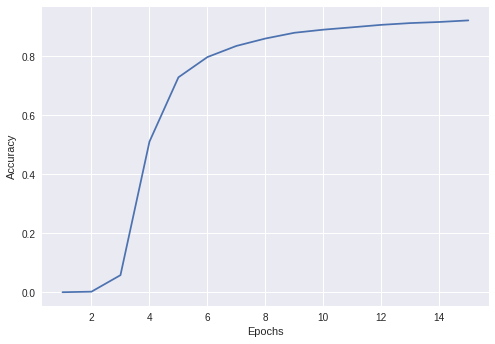

In [97]:
score = model.evaluate(x_test, y_testEnc, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()